# Import libraries needed

In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline 

*Loading the data*

In [2]:
htspch = pd.read_csv("data_hatespeech.csv") 

In [3]:
htspch.head() #display top of the data

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: Kama dem hufai kulalamik...
1,1,3,0,3,0,1,!!!!! RT @mleew17: buda hio ni baridi...kuonge...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based alkuwa...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: Chenye unask...


In [4]:
htspch.describe() #describe the data

,Unnamed: 0,count,hate_speech,offensive_language,neither,class
count,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000
mean,665.011765,3.190588,0.250196,2.369412,0.570980,1.117647
std,395.672350,0.775755,0.583114,1.304204,1.156623,0.455520
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,323.500000,3.000000,0.000000,2.000000,0.000000,1.000000
50%,647.000000,3.000000,0.000000,3.000000,0.000000,1.000000
75%,1024.500000,3.000000,0.000000,3.000000,0.000000,1.000000
max,1350.000000,9.000000,3.000000,9.000000,9.000000,2.000000


In [5]:
htspch.columns #display columns

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')

<h3>Column Key:</h3>

hate_speech = number of users who judged the tweet to be hate speech.

offensive_language = number of users who judged the tweet to be offensive.

neither = number of users who judged the tweet to be neither offensive nor non-offensive.

class = class label for majority of CF users.

0 - hate speech
1 - offensive  language
2 - neither
tweet = raw tweet text

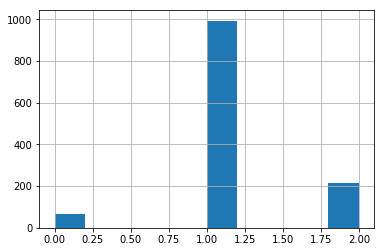

In [6]:
# plot a graph for the classes
htspch['class'].hist()

In [7]:
tweets = htspch.tweet

# Feature Generation

In [8]:
#Words without important significance
stopwords=stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

#Reducing words to its root
stemmer = PorterStemmer()

def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'

    #re.sub function:
    #it replaces the first attribute with the second attribute and joins it with the third attribute
    
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

#define a tfidf vectorizer that is used to transforms text to feature vectors that can be used as input to estimator. 
vectorizer = TfidfVectorizer(
    tokenizer = tokenize,
    preprocessor = preprocess,
    ngram_range = (1,3),
    stop_words = stopwords,
    use_idf = True,
    smooth_idf = False,
    norm = None,
    decode_error = 'replace',
    max_features = 1000,
    min_df = 0.1,
    max_df = 0.7
    )

# Ignore Warnings

In [9]:
import warnings
warnings.simplefilter(action = 'ignore',category = FutureWarning)

# Construct tfidf matrix and get relevant scores

In [10]:
#Transform tweets to arrays
tfidf = vectorizer.fit_transform(tweets).toarray()
#dictionary that converts each token (word) to feature index in the matrix, each unique token gets a feature index
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}#dictionary with feature names of the tweets
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

In [11]:
#Get POS tags for tweets and save as a string
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

In [12]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [13]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

In [14]:
#Now get other features
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet) #Get text only
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [15]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

In [16]:
feats = get_feature_array(tweets)

In [17]:
#Now join them all up
M = np.concatenate([tfidf,pos,feats],axis=1)

In [18]:
M.shape

(1275, 831)

In [19]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

# Running the model

The best model was selected using a GridSearch with 5-fold CV.

In [20]:
X = pd.DataFrame(M)
y = htspch['class'].astype(int)

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [23]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline

In [24]:
pipe = Pipeline(
        [('select', SelectFromModel(LogisticRegression(class_weight='balanced',
                                                  penalty="l1", C=0.01))),
        ('model', LogisticRegression(class_weight='balanced',penalty='l2'))])

In [25]:
param_grid = [{}] # Optionally add parameters here

In [26]:
grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, 
                                              random_state=42).split(X_train, y_train), 
                           verbose=2)

In [27]:
model = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................
[CV] ................................................. , total=   0.1s
[CV]  ................................................................
[CV] ................................................. , total=   0.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ................................................. , total=   0.1s
[CV]  ................................................................
[CV] ................................................. , total=   0.1s
[CV]  ................................................................
[CV] ................................................. , total=   0.1s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished


In [28]:
#check how many unique classes
d =np.unique
print(d)

<function unique at 0x7f8ba810f620>


In [29]:
y_preds = model.predict(X_test)

## Evaluating the results

In [30]:
report = classification_report( y_test, y_preds )

***Here the results are reported after using cross-validation and only for the held-out set.***

In [31]:
print(report)

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         6
          1       0.88      0.68      0.76        96
          2       0.39      0.65      0.49        26

avg / total       0.74      0.64      0.67       128



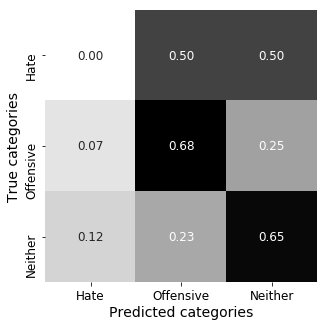

In [32]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

#Uncomment line below if you want to save the output
#plt.savefig('confusion.pdf')

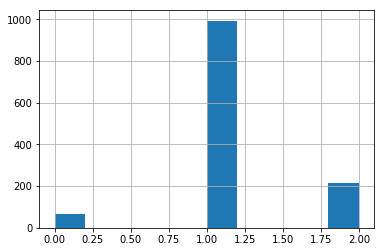

In [33]:
y.hist()

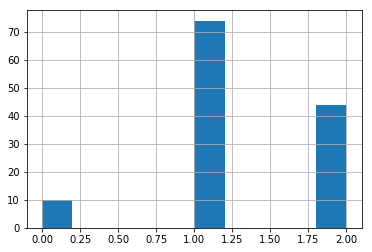

In [34]:
pd.Series(y_preds).hist()